# Peak shaving vs TCIPC analysis.

## Loading data

In [125]:
import socket

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata
from weis.visualization.utils import load_OMsql_multi

socket.gethostname()  # Should not be a login node.

'J1YCSV3'

In [126]:
# Load the data.
log_fmt = "../../data/design_of_experiments/ps_vs_ipc/log_ps_vs_ipc.sql*"
data_dict = load_OMsql_multi(log_fmt)
data_dict.keys()

This process (pid=210588) is multi-threaded, use of fork() may lead to deadlocks in the child.

dict_keys(['aeroelastic.platform_displacement', 'aeroelastic.hub_system_cm', 'aeroelastic.platform_elem_rho', 'aeroelastic.platform_elem_E', 'aeroelastic.platform_elem_G', 'aeroelastic.platform_total_center_of_mass', 'aeroelastic.platform_mass', 'aeroelastic.platform_I_total', 'aeroelastic.beta_wave', 'aeroelastic.gamma_f', 'aeroelastic.gamma_m', 'aeroelastic.E', 'aeroelastic.twr2shaft', 'aeroelastic.Xt', 'aeroelastic.Xc', 'aeroelastic.m', 'aeroelastic.definition_layer', 'aeroelastic.sc_ss_mats', 'aeroelastic.sc_ps_mats', 'aeroelastic.te_ss_mats', 'aeroelastic.te_ps_mats', 'aeroelastic.monopile_wohlerexp', 'aeroelastic.monopile_wohlerA', 'aeroelastic.monopile_ultstress', 'aeroelastic.pitch_axis', 'aeroelastic.monopile_axial_load2stress', 'aeroelastic.monopile_shear_load2stress', 'aeroelastic.transition_node', 'aeroelastic.platform_nodes', 'aeroelastic.platform_elem_n1', 'aeroelastic.platform_elem_n2', 'aeroelastic.platform_elem_D', 'aeroelastic.platform_elem_t', 'aeroelastic.AEP', 'aer

In [296]:
# Let's define how we load, scale, and label the data, then make a dataframe.
all_outputs = {
    # Design variables
    "TCIPC_MaxTipDeflection": {
        "key": "tune_rosco_ivc.TCIPC_MaxTipDeflection",
        "scaling": lambda x: x,
        "label": "TCIPC Max Tip Deflection (m)",
    },
    "ps_percent": {
        "key": "tune_rosco_ivc.ps_percent",
        "scaling": lambda x: x,
        "label": "Peak Shaving (%)",
    },
    # Objectives / responses
    "aep": {
        "key": "aeroelastic.AEP",
        "scaling": lambda x: 1e-6 * x,  # kWh -> GWh
        "label": "AEP (GWh)",
    },
    "max_TipDxc_towerPassing": {
        "key": "aeroelastic.max_TipDxc_towerPassing",
        "scaling": lambda x: x,
        "label": "Max TipDxc Tower Passing (m)",
    },
    "tower_clearance": {
        "key": "aeroelastic.max_TipDxc_towerPassing",
        "scaling": lambda x: 30 - x,
        "label": "Tower clearance (m)",
    },
    "avg_pitch_travel": {
        "key": "aeroelastic.avg_pitch_travel",
        "scaling": lambda x: x,
        "label": "Avg Pitch Travel (deg)",
    },
    "DEL_RootMyb": {
        "key": "aeroelastic.DEL_RootMyb",
        "scaling": lambda x: x,  # Assuming kNm already
        "label": "DEL Root Myb (kNm)",
    },
    "max_TwrBsMyt": {
        "key": "aeroelastic.max_TwrBsMyt",
        "scaling": lambda x: x,  # Assuming kNm already
        "label": "Max Tower Base Myt (kNm)",
    },
}

# Build dataframe from mapping
labels = {short: info["label"] for short, info in all_outputs.items()}
df_dict = {}
for short_label, info in all_outputs.items():
    data = data_dict[info["key"]]
    scaled_data = list(map(info["scaling"], data))
    df_dict[short_label] = scaled_data

df = pd.DataFrame(df_dict)
df.head()

,TCIPC_MaxTipDeflection,ps_percent,aep,max_TipDxc_towerPassing,tower_clearance,avg_pitch_travel,DEL_RootMyb,max_TwrBsMyt
0,0.0,0.5,69.873721,6.438586,23.561414,1.132866,40174.151410,238702.734375
1,8.0,0.5,69.338518,10.330774,19.669226,0.253252,20649.257022,211134.703125
2,16.0,0.5,69.338651,10.980695,19.019305,0.240810,20738.599862,203290.890625
3,0.0,0.6,77.284748,7.696049,22.303951,1.224247,42337.360675,250177.078125
4,8.0,0.6,76.109484,10.757485,19.242515,0.326189,22287.002688,237616.687500


## Some sanity checks

<Axes: xlabel='TCIPC_MaxTipDeflection', ylabel='ps_percent'>

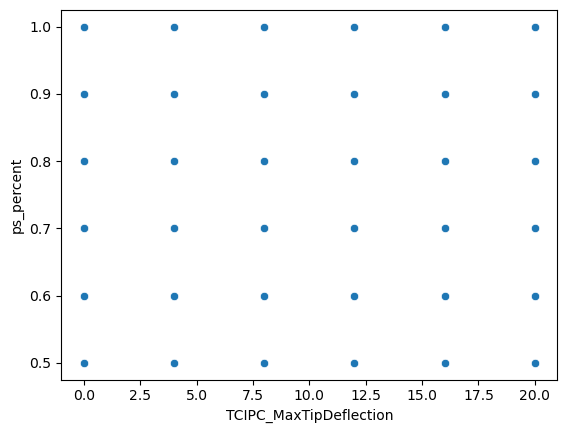

In [297]:
# Make a plot of the distribution of our design variables.
sns.scatterplot(
    df,
    x="TCIPC_MaxTipDeflection",
    y="ps_percent",
)

## Data exploration

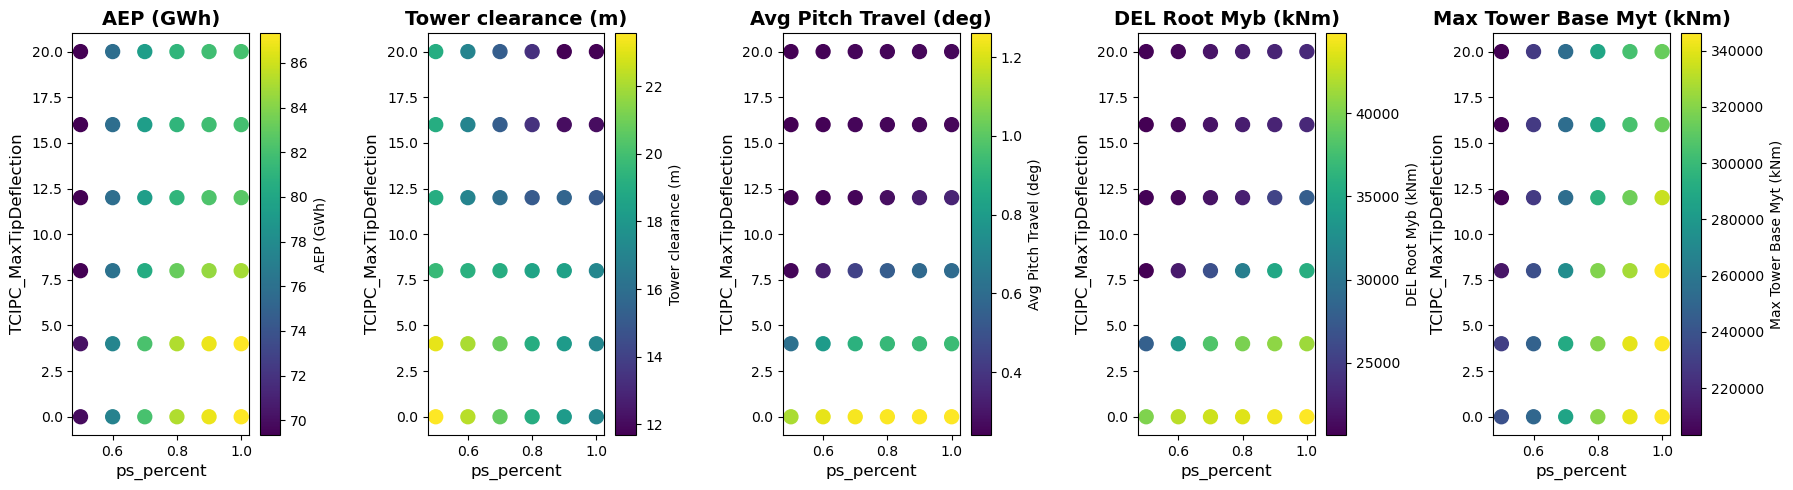

In [298]:
# Plot the objectives as a function of our design variables.

# Output variables to plot (use short names)
outputs = [
    "aep",
    "tower_clearance",
    "avg_pitch_travel",
    "DEL_RootMyb",
    "max_TwrBsMyt",
]

# Create figure with enough subplots for the outputs.
fig, axes = plt.subplots(1, len(outputs), figsize=(18, 5))

# Create scatter plots with color representing each output
for idx, output in enumerate(outputs):
    scatter = axes[idx].scatter(
        df["ps_percent"],
        df["TCIPC_MaxTipDeflection"],
        c=df[output],
        cmap="viridis",
        s=100,
    )
    axes[idx].set_xlabel("ps_percent", fontsize=12)
    axes[idx].set_ylabel("TCIPC_MaxTipDeflection", fontsize=12)
    label_txt = labels.get(output, output)
    axes[idx].set_title(label_txt, fontsize=14, fontweight="bold")
    plt.colorbar(scatter, ax=axes[idx], label=label_txt)

plt.tight_layout()
plt.show()


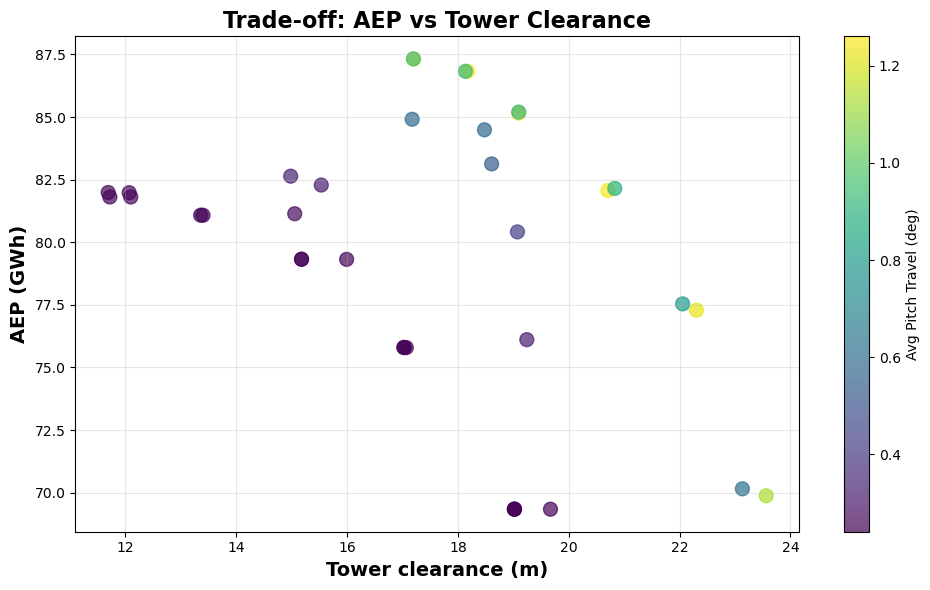

In [299]:
# Trade-off plot between AEP and Tower Clearance
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    df["tower_clearance"],
    df["aep"],
    c=df["avg_pitch_travel"],
    cmap="viridis",
    s=100,
    alpha=0.7,
)

ax.set_xlabel(
    labels.get("tower_clearance", "Tower Clearance (m)"), fontsize=14, fontweight="bold"
)
ax.set_ylabel(labels["aep"], fontsize=14, fontweight="bold")
ax.set_title("Trade-off: AEP vs Tower Clearance", fontsize=16, fontweight="bold")
plt.colorbar(scatter, ax=ax, label=labels["avg_pitch_travel"])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Data interpolation

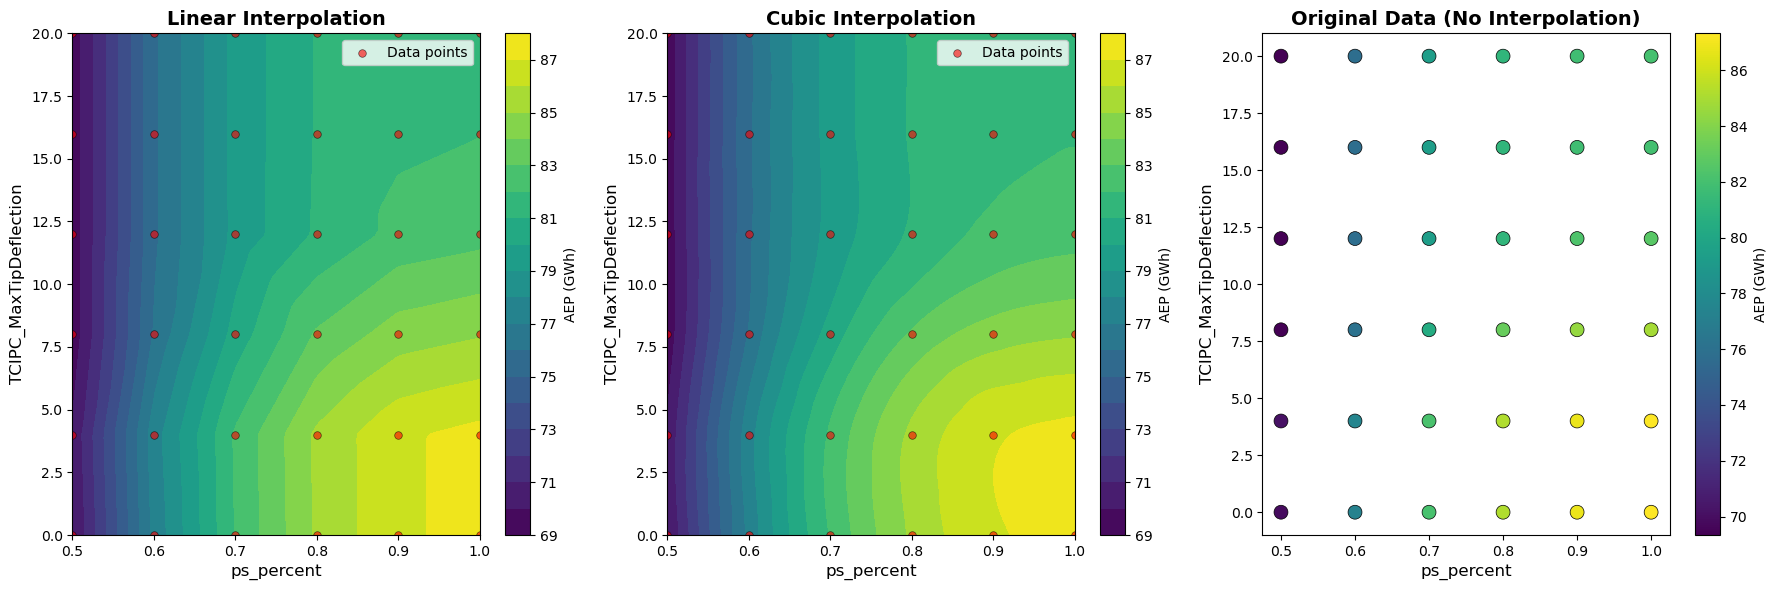

In [300]:
# What type of interpolation should we use? From this I think cubic interpolation works
# very well.
ps_min, ps_max = (
    df["ps_percent"].min(),
    df["ps_percent"].max(),
)
tip_min, tip_max = (
    df["TCIPC_MaxTipDeflection"].min(),
    df["TCIPC_MaxTipDeflection"].max(),
)

# Create meshgrid for interpolation
grid_ps = np.linspace(ps_min, ps_max, 100)
grid_tip = np.linspace(tip_min, tip_max, 100)
grid_ps_mesh, grid_tip_mesh = np.meshgrid(grid_ps, grid_tip)

# Prepare input points
points = df[["ps_percent", "TCIPC_MaxTipDeflection"]].values

# Output to interpolate (use scaled aep)
output = "aep"
values = df[output].values

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Linear interpolation
grid_z = griddata(points, values, (grid_ps_mesh, grid_tip_mesh), method="linear")
im = axes[0].contourf(grid_ps_mesh, grid_tip_mesh, grid_z, levels=20, cmap="viridis")
axes[0].scatter(
    df["ps_percent"],
    df["TCIPC_MaxTipDeflection"],
    c="red",
    s=30,
    edgecolors="black",
    linewidth=0.5,
    alpha=0.6,
    label="Data points",
)
axes[0].set_xlabel("ps_percent", fontsize=12)
axes[0].set_ylabel("TCIPC_MaxTipDeflection", fontsize=12)
axes[0].set_title("Linear Interpolation", fontsize=14, fontweight="bold")
plt.colorbar(im, ax=axes[0], label="AEP (GWh)")
axes[0].legend()

# Cubic interpolation
grid_z = griddata(points, values, (grid_ps_mesh, grid_tip_mesh), method="cubic")
im = axes[1].contourf(grid_ps_mesh, grid_tip_mesh, grid_z, levels=20, cmap="viridis")
axes[1].scatter(
    df["ps_percent"],
    df["TCIPC_MaxTipDeflection"],
    c="red",
    s=30,
    edgecolors="black",
    linewidth=0.5,
    alpha=0.6,
    label="Data points",
)
axes[1].set_xlabel("ps_percent", fontsize=12)
axes[1].set_ylabel("TCIPC_MaxTipDeflection", fontsize=12)
axes[1].set_title("Cubic Interpolation", fontsize=14, fontweight="bold")
plt.colorbar(im, ax=axes[1], label="AEP (GWh)")
axes[1].legend()

# Original scatter for comparison
scatter = axes[2].scatter(
    df["ps_percent"],
    df["TCIPC_MaxTipDeflection"],
    c=values,
    cmap="viridis",
    s=100,
    edgecolors="black",
    linewidth=0.5,
)
axes[2].set_xlabel("ps_percent", fontsize=12)
axes[2].set_ylabel("TCIPC_MaxTipDeflection", fontsize=12)
axes[2].set_title("Original Data (No Interpolation)", fontsize=14, fontweight="bold")
plt.colorbar(scatter, ax=axes[2], label="AEP (GWh)")

plt.tight_layout()
plt.show()


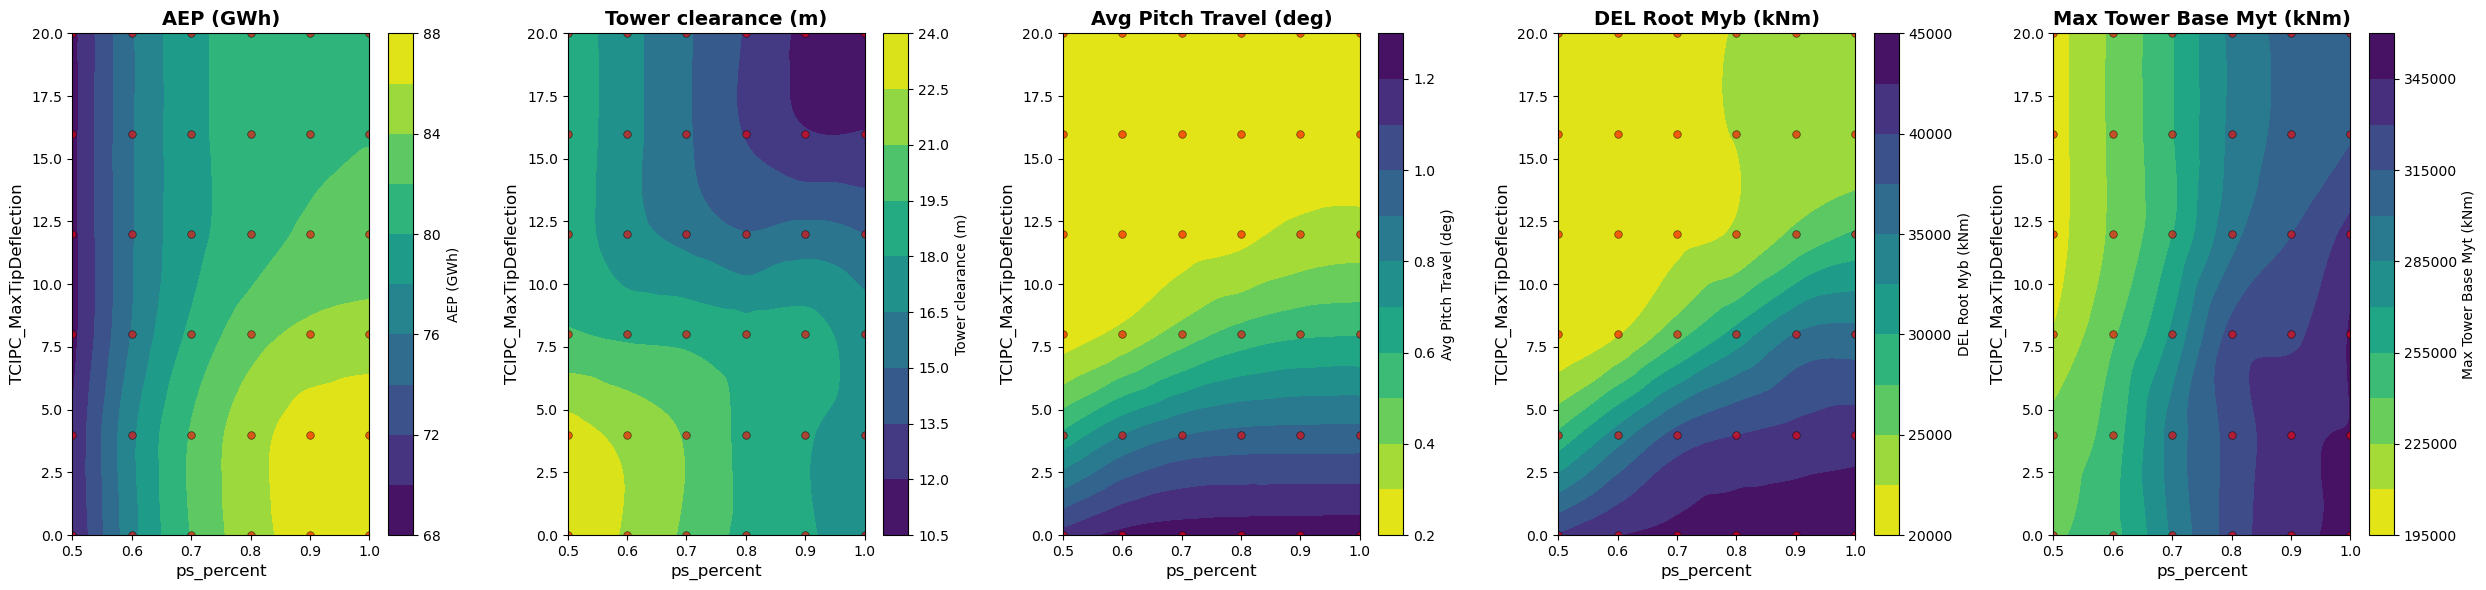

In [301]:
# Cubic interpolation for all selected outputs
fig, axes = plt.subplots(1, len(outputs), figsize=(25, 6))

# Use some reverse color maps when it is an objective we want to minimize.
cmaps = ["viridis", "viridis", "viridis_r", "viridis_r", "viridis_r"]

for idx, output in enumerate(outputs):
    values = df[output].values

    # Cubic interpolation
    grid_z = griddata(points, values, (grid_ps_mesh, grid_tip_mesh), method="cubic")
    im = axes[idx].contourf(
        grid_ps_mesh, grid_tip_mesh, grid_z, levels=10, cmap=cmaps[idx]
    )
    axes[idx].scatter(
        df["ps_percent"],
        df["TCIPC_MaxTipDeflection"],
        c="red",
        s=30,
        edgecolors="black",
        linewidth=0.5,
        alpha=0.6,
        label="Data points",
    )
    axes[idx].set_xlabel("ps_percent", fontsize=12)
    axes[idx].set_ylabel("TCIPC_MaxTipDeflection", fontsize=12)
    axes[idx].set_title(labels.get(output, output), fontsize=14, fontweight="bold")
    plt.colorbar(im, ax=axes[idx], label=labels.get(output, output))

plt.tight_layout()
plt.show()


## Optimization

TODO: Clean this up a bit and maybe also make it more general for some future
investigations (hmm, yeah too general without using it for something general is
also a bit strange). But a little cleanup should for sure be possible.

In [302]:
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from scipy.interpolate import CloughTocher2DInterpolator


xy = df[["ps_percent", "TCIPC_MaxTipDeflection"]].values

aep_interpolator = CloughTocher2DInterpolator(xy, -df["aep"].values)  # type: ignore
tower_clearance_interpolator = CloughTocher2DInterpolator(
    xy,
    -df["tower_clearance"].values,  # type: ignore
)


class TuningProblem(ElementwiseProblem):
    def __init__(self, objective_functions, xl=None, xu=None):
        # Set some defaults.
        if xl is None:
            xl = np.array([0.5, 0.0])
        if xu is None:
            xu = np.array([1.0, 20.0])

        super().__init__(
            n_var=2,
            n_obj=len(objective_functions),
            n_ieq_constr=0,
            xl=xl,
            xu=xu,
        )

        self.objective_functions = objective_functions

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = [f(*x) for f in self.objective_functions]


problem_baseline = TuningProblem(
    [aep_interpolator, tower_clearance_interpolator],
    xl=np.array([0.5, 20.0]),
)
problem_tcipc = TuningProblem([aep_interpolator, tower_clearance_interpolator])

# algorithm = NSGA2(
#     pop_size=40,
#     n_offsprings=10,
#     sampling=FloatRandomSampling(),
#     crossover=SBX(prob=0.9, eta=15),
#     mutation=PM(eta=20),
#     eliminate_duplicates=True,
# )
ref_dirs = get_reference_directions("uniform", 2, n_partitions=50)
# algorithm = MOEAD(
#     ref_dirs,
#     n_neighbors=50,
#     prob_neighbor_mating=0.7,
# )
algorithm = CTAEA(ref_dirs)  # I found this one to work very well.


termination = get_termination("n_gen", 30)

result_baseline = minimize(
    problem_baseline, algorithm, termination, seed=1, save_history=True, verbose=True
)
result_tcipc = minimize(
    problem_tcipc, algorithm, termination, seed=1, save_history=True, verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       51 |     43 |             - |             -
     2 |      102 |     51 |  0.0060035066 |             f
     3 |      153 |     51 |  0.0040335120 |             f
     4 |      204 |     51 |  0.0035774880 |             f
     5 |      255 |     51 |  0.0022271659 |             f
     6 |      306 |     51 |  0.0034763198 |             f
     7 |      357 |     51 |  0.0009803078 |             f
     8 |      408 |     51 |  0.0026460522 |             f
     9 |      459 |     51 |  0.0009039395 |             f
    10 |      510 |     51 |  0.0009801412 |             f
    11 |      561 |     51 |  0.0011680573 |             f
    12 |      612 |     51 |  0.0013504456 |             f
    13 |      663 |     51 |  0.0014592106 |             f
    14 |      714 |     51 |  0.0018708563 |             f
    15 |      765 |     51 |  0.0019833254 |             f
    16 |      816 |     51 |  0.0020574112 |            

The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecatedDeprecationWarning: /home/jesse/miniconda3/envs/tip_clearance/lib/python3.13/site-packages/pymoo/core/individual.py:618
The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated

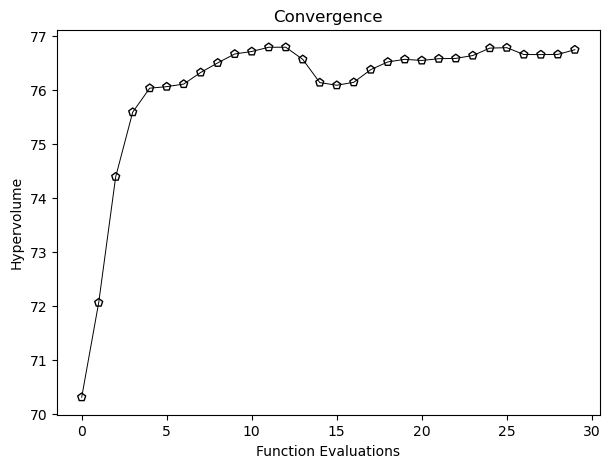

In [303]:
# Analyze convergence.
from pymoo.indicators.hv import Hypervolume

# Get history
n_evals = []  # corresponding number of function evaluations\
hist_F = []  # the objective space values in each generation
hist_cv = []  # constraint violation in each generation
hist_cv_avg = []  # average constraint violation in the whole population

for algo in result_tcipc.history:
    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

approx_ideal = result_tcipc.F.min(axis=0)
approx_nadir = result_tcipc.F.max(axis=0)
ref_point = approx_nadir

metric = Hypervolume(
    # ref_point=np.array([90, 20]),
    ref_point=ref_point,
    norm_ref_point=False,
    zero_to_one=False,
    ideal=approx_ideal,
    nadir=approx_nadir,
)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(hv, color="black", lw=0.7, label="Avg. CV of Pop")
plt.scatter(range(len(hv)), hv, facecolor="none", edgecolor="black", marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

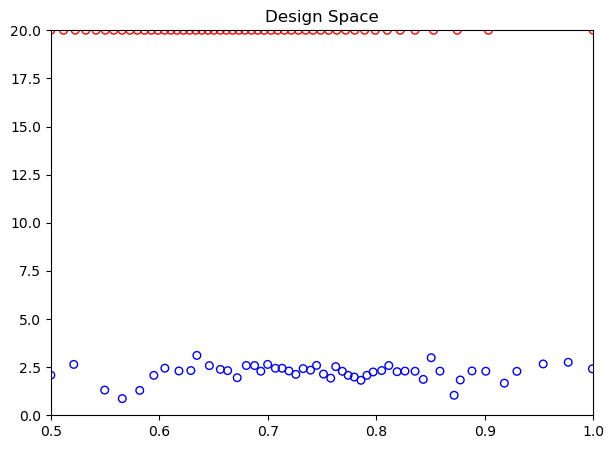

In [304]:
# Visualize.
xl, xu = problem_tcipc.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(
    result_baseline.X[:, 0],
    result_baseline.X[:, 1],
    s=30,
    facecolors="none",
    edgecolors="r",
)
plt.scatter(
    result_tcipc.X[:, 0], result_tcipc.X[:, 1], s=30, facecolors="none", edgecolors="b"
)
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

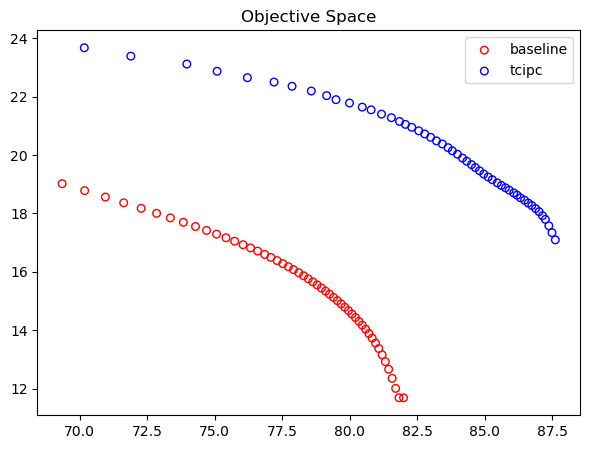

In [305]:
# Visualize.
plt.figure(figsize=(7, 5))
plt.scatter(
    -result_baseline.F[:, 0],
    -result_baseline.F[:, 1],
    s=30,
    facecolors="none",
    edgecolors="r",
)
plt.scatter(
    -result_tcipc.F[:, 0],
    -result_tcipc.F[:, 1],
    s=30,
    facecolors="none",
    edgecolors="b",
)
plt.legend(["baseline", "tcipc"])
plt.title("Objective Space")
plt.show()

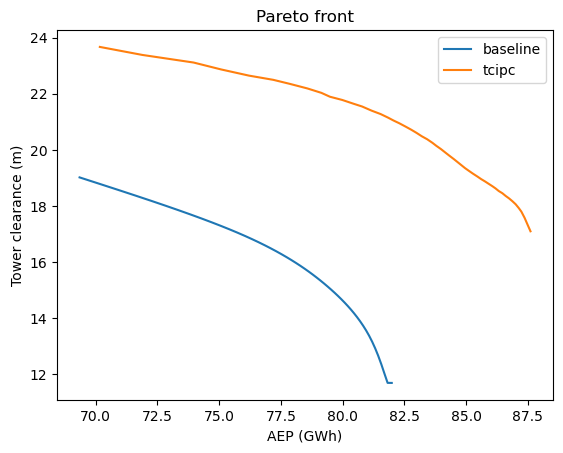

In [306]:
# Making a line plot.
pareto_baseline = -result_baseline.F[result_baseline.F[:, 0].argsort()]  # type: ignore
pareto_tcipc = -result_tcipc.F[result_tcipc.F[:, 0].argsort()]  # type: ignore

plt.plot(*np.transpose(pareto_baseline), label="baseline")
plt.plot(*np.transpose(pareto_tcipc), label="tcipc")
plt.legend()
plt.xlabel("AEP (GWh)")
plt.ylabel("Tower clearance (m)")
plt.title("Pareto front")
plt.show()